In [58]:
import os
import numpy as np
import cv2
import re
import requests
from bs4 import BeautifulSoup
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


# Function to resize images to 32x30 and Normalize to [0,1]
def resize_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (32, 30))
    return resized_img / 255.0

# Function to parse labels from filenames
def parse_label(filename):
    if "sunglasses" in filename:
        return 1
    else:
        return 0

# Create the base directory if it doesn't exist
base_directory = "/content/faces"
if not os.path.exists(base_directory):
    os.makedirs(base_directory)

# Function to download files from a subdirectory URL
def download_files(subdirectory_url, base_directory):
    response = requests.get(subdirectory_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        rows = soup.find_all('tr')[3:]
        for row in rows:
            try:
                td = row.find_all('td')[1]
                a = td.find('a')
                file_url = subdirectory_url + a.get('href')
                filename = a.get('href').split("/")[-1]
                filepath = os.path.join(base_directory, filename)
                if not os.path.exists(filepath):
                    file_response = requests.get(file_url)
                    with open(filepath, "wb") as file:
                        file.write(file_response.content)
                else:
                    print(f"Skipping: {filename} already exists")
            except Exception as e:
                print(f"Downloading from directory {subdirectory_url} completed")

# Get user input for the number of image directories to download
num_directories = int(input("Enter the number of image directories you want to download from: "))

# Main URL of the webpage
main_url = "https://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-8/faceimages/faces/"

# Send a GET request to the main page
main_response = requests.get(main_url)
if main_response.status_code == 200:
    main_soup = BeautifulSoup(main_response.content, 'html.parser')
    main_rows = main_soup.find_all('tr')[3:]
    total_directories_downloaded = 0
    for main_row in main_rows:
        try:
            main_td = main_row.find_all('td')[1]
            main_a = main_td.find('a')
            subdirectory_url = main_url + main_a.get('href')
            download_files(subdirectory_url, base_directory)
            total_directories_downloaded += 1
            if total_directories_downloaded >= num_directories:
                print(f"Number of image directories downloaded: {total_directories_downloaded}")
                break
        except Exception as e:
            print(f"Skipping row: {str(e)}")
else:
    print("Failed to fetch main webpage.")

# Load dataset
data_path = "/content/faces"
image_files = os.listdir(data_path)
X = []
y = []
for file in image_files:
    if file.endswith(".pgm"):
        image_path = os.path.join(data_path, file)
        resized_image = resize_image(image_path)
        X.append(resized_image.flatten())
        label = parse_label(file)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split data into training and testing sets (80% train, 20% test)
num_samples = len(X)
num_train_samples = int(0.8 * num_samples)
train_indices = np.random.choice(num_samples, num_train_samples, replace=False)
test_indices = np.array(list(set(range(num_samples)) - set(train_indices)))

# Check for any out-of-bounds indices in y
if np.any(train_indices >= len(y)) or np.any(test_indices >= len(y)):
    print("Indices out of bounds for y.")
else:
    # Proceed with splitting X and y
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

# Define the neural network architecture
input_size = 960
hidden_size = 1000
output_size = 1  # Binary classification for wearing sunglasses or not

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases and momentum term
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_output = np.zeros((1, self.output_size))
        self.momentum = 0.09
        self.m_vector_weight_hidden , self.m_vector_weight_output, self.m_vector_bias_hidden, self.m_vector_bias_output = 0 , 0 , 0 ,0

    def forward(self, inputs):
        # Forward pass
        # Input to hidden layer
        self.hidden_sum = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
        self.hidden_activation = self.sigmoid(self.hidden_sum)

        # Hidden to output layer
        self.output_sum = np.dot(self.hidden_activation, self.weights_hidden_output) + self.bias_output
        self.output = self.sigmoid(self.output_sum)

        return self.output

    def backward(self, inputs, targets, learning_rate):
        # Backward pass
        # Calculate error
        output_error = targets - self.output

        # Calculate gradients
        output_delta = output_error * self.sigmoid_derivative(self.output)
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_activation)

        # calculating the momentum coefficients
        self.m_vector_weight_output = np.dot(self.hidden_activation.T, output_delta) * (self.momentum) + self.m_vector_weight_output * ( 1 -self.momentum)
        self.m_vector_bias_output = np.sum(output_delta, axis=0, keepdims=True) * (self.momentum) + self.m_vector_bias_output * ( 1 -self.momentum)
        self.m_vector_weight_hidden = np.dot(inputs.T, hidden_delta) * (self.momentum) + self.m_vector_weight_hidden * ( 1 -self.momentum)
        self.m_vector_bias_hidden = np.sum(hidden_delta, axis=0, keepdims=True) * (self.momentum) + self.m_vector_bias_hidden * ( 1 -self.momentum)

        # Update weights and biases
        self.weights_hidden_output += learning_rate * self.m_vector_weight_output
        self.bias_output += learning_rate * self.m_vector_bias_output
        self.weights_input_hidden += learning_rate * self.m_vector_weight_hidden
        self.bias_hidden += learning_rate * self.m_vector_bias_hidden


    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def train(self, X_train, y_train, epochs=1000, learning_rate=0.01):
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X_train)

            # Backward pass
            self.backward(X_train, y_train, learning_rate)

            # Print error every 100 epochs
            if epoch % 100 == 0:
                error = np.mean(np.square(y_train - output))
                print(f'Error at epoch {epoch}: {error}')

    def evaluate_accuracy(self, X_test, y_test):
        predictions = np.round(self.forward(X_test))
        accuracy = np.mean(predictions == y_test)
        print("Accuracy:", accuracy)
        return predictions
    def evaluate_f1_score(self, X_test, y_test):
      predictions = np.round(self.forward(X_test))
      f1_Score = f1_score(y_test, predictions)
      print("F1 Score:", f1_Score)
      return f1_Score


Enter the number of image directories you want to download from: 10
Skipping: an2i_left_angry_open.pgm already exists
Skipping: an2i_left_angry_open_2.pgm already exists
Skipping: an2i_left_angry_open_4.pgm already exists
Skipping: an2i_left_angry_sunglasses.pgm already exists
Skipping: an2i_left_angry_sunglasses_2.pgm already exists
Skipping: an2i_left_angry_sunglasses_4.pgm already exists
Skipping: an2i_left_happy_open.pgm already exists
Skipping: an2i_left_happy_open_2.pgm already exists
Skipping: an2i_left_happy_open_4.pgm already exists
Skipping: an2i_left_happy_sunglasses.pgm already exists
Skipping: an2i_left_happy_sunglasses_2.pgm already exists
Skipping: an2i_left_happy_sunglasses_4.pgm already exists
Skipping: an2i_left_neutral_open.pgm already exists
Skipping: an2i_left_neutral_open_2.pgm already exists
Skipping: an2i_left_neutral_open_4.pgm already exists
Skipping: an2i_left_neutral_sunglasses.pgm already exists
Skipping: an2i_left_neutral_sunglasses_2.pgm already exists
Sk

Error at epoch 0: 0.4310808288410748
Error at epoch 100: 0.013711903735755726
Error at epoch 200: 0.013403846060268926
Error at epoch 300: 0.013357869654393627
Error at epoch 400: 0.013333236584903187
Accuracy: 0.9735449735449735
F1 Score: 0.9735449735449735


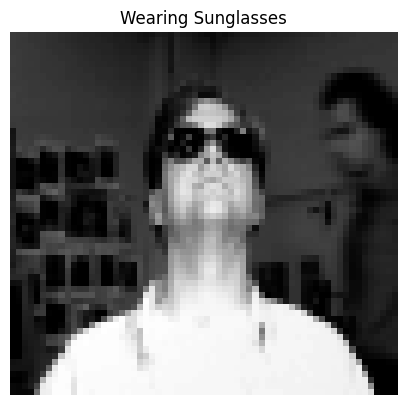

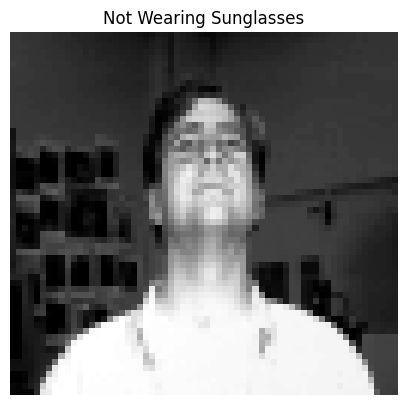

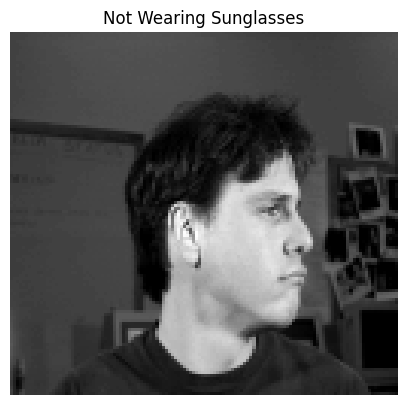

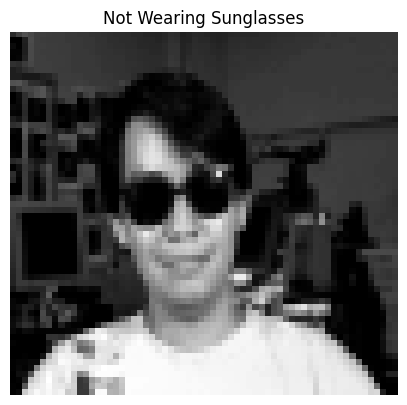

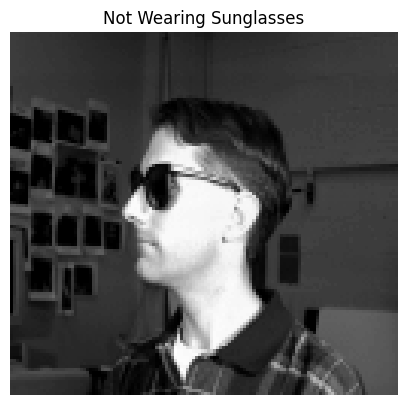

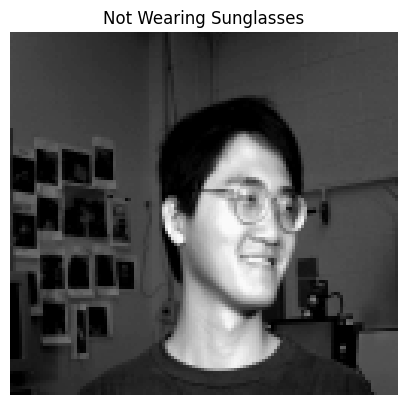

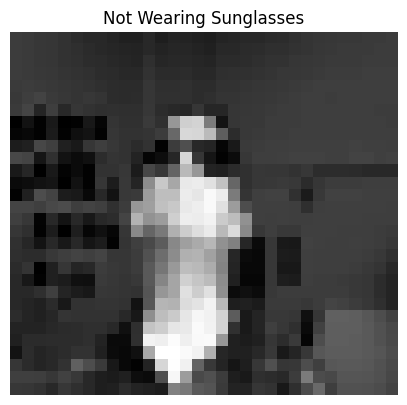

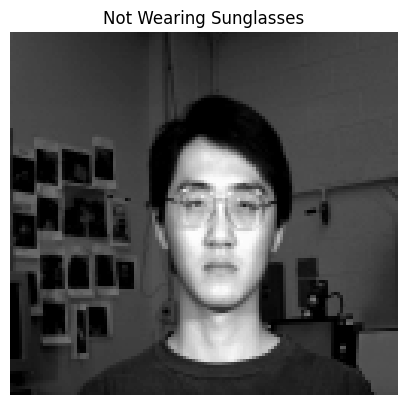

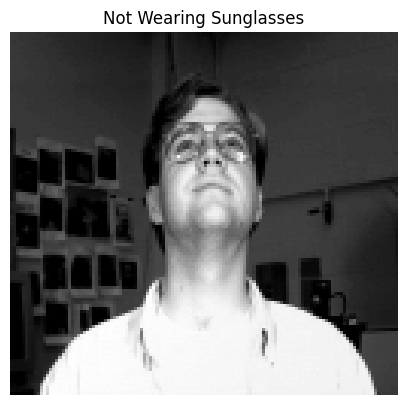

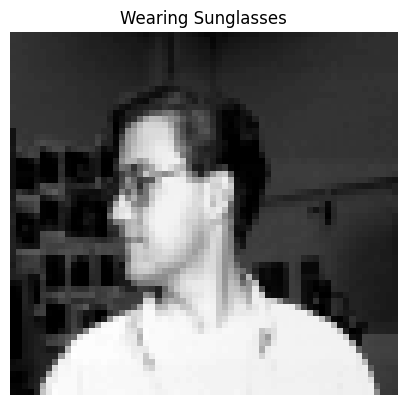

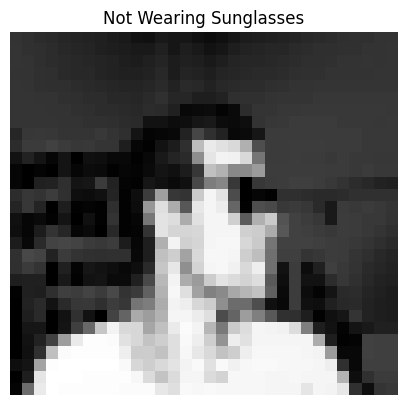

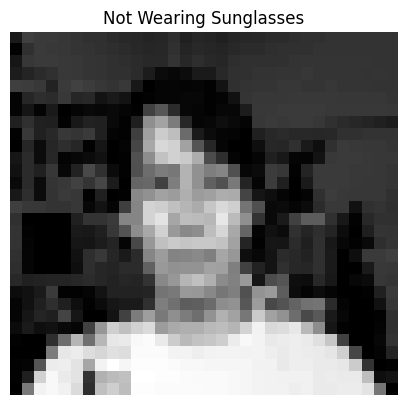

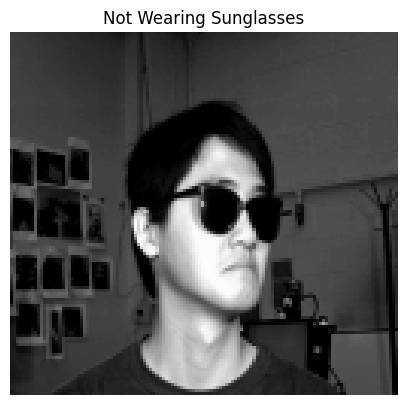

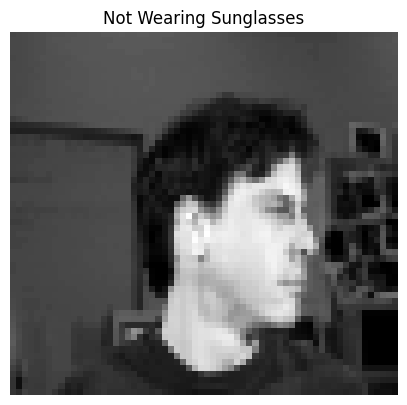

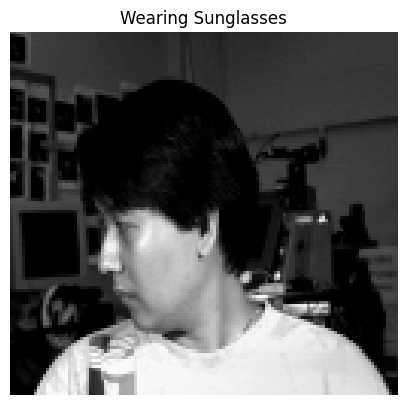

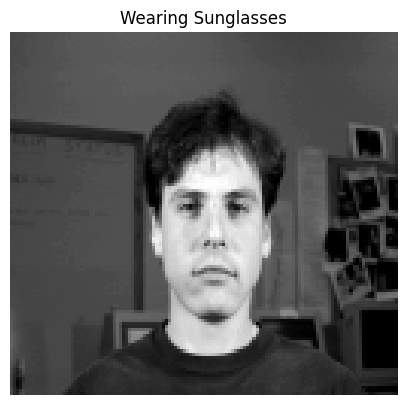

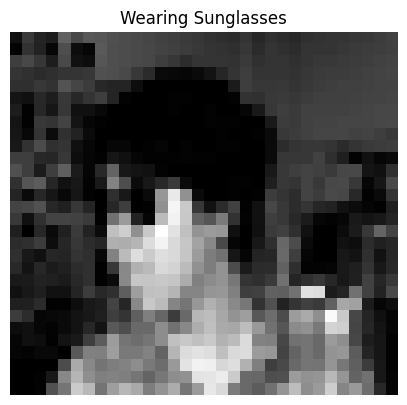

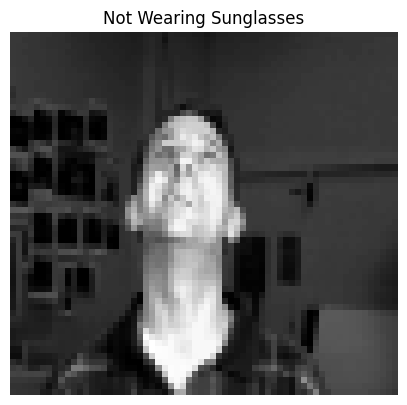

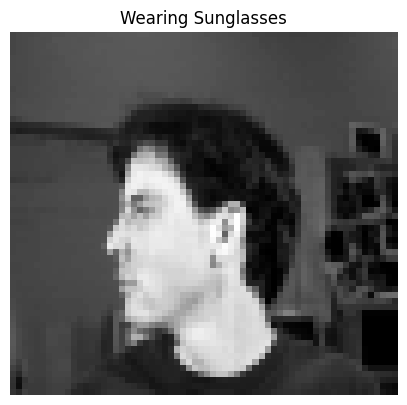

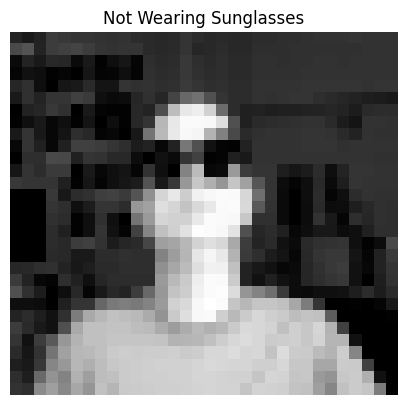

In [59]:

# Create a neural network instance
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the neural network
nn.train(X_train, y_train.reshape(-1, 1), epochs = 500)

# Evaluate the
# Evaluate the accuracy of the neural network
predictions = nn.evaluate_accuracy(X_test, y_test.reshape(-1, 1))
f1_Score = nn.evaluate_f1_score(X_test, y_test.reshape(-1, 1))

# Function to display images with predicted labels
def display_images_with_predictions(names, predictions, path, max_images=10):
    images = []
    predicted_labels = []
    num_images = min(len(names), max_images)
    for i in range(num_images):
        filename = names[i]
        image_path = os.path.join(path, filename)
        img = Image.open(image_path)
        images.append(img)
        label = "Wearing Sunglasses" if predictions[i] == 1 else "Not Wearing Sunglasses"
        predicted_labels.append(label)
    return images, predicted_labels

# Define the path to the directory where the images are located
path_to_images = "/content/faces/"

# Call the function to get images and predicted labels separately
images, predicted_labels = display_images_with_predictions(image_files, predictions, path=path_to_images, max_images=20)

# Display images and predicted labels separately
for i in range(len(images)):
    plt.figure(figsize=(5, 5))
    plt.imshow(images[i], cmap='gray')
    plt.title(predicted_labels[i])
    plt.axis('off')
    plt.show()

In [60]:
import pickle

# Define the directory where you want to save the model
model_directory = "/googledrive/MyDrive/ML-LAB/ML-Assignment"

# Create the directory if it doesn't exist
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the trained neural network model
model_filename = os.path.join(model_directory, "sunglasses_prediction_model.pkl")
with open(model_filename, 'wb') as file:
    pickle.dump(nn, file)

print("Model saved successfully at:", model_filename)

Model saved successfully at: /googledrive/MyDrive/ML-LAB/ML-Assignment/sunglasses_prediction_model.pkl


In [61]:
import pickle
# Load the saved model
def load_model(load_path):
    with open(load_path, 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model

# Load the saved model
loaded_model = load_model('/googledrive/MyDrive/ML-LAB/ML-Assignment/sunglasses_prediction_model.pkl')

# Function to predict label for a single image using the loaded model
def predict_single_image_from_dataset(data_path, model):
    # Get list of .pgm files in the dataset directory
    image_files = [file for file in os.listdir(data_path) if file.endswith(".pgm")]
    # Select a random image file from the dataset
    image_filename = np.random.choice(image_files)
    image_path = os.path.join(data_path, image_filename)
    # Resize and flatten the image
    resized_image = resize_image(image_path)
    flattened_image = resized_image.flatten()
    # Predict label using the model
    prediction = model.forward(flattened_image.reshape(1, -1))
    label = "Wearing Sunglasses" if prediction >= 0.5 else "Not Wearing Sunglasses"
    return image_filename, label

# Test the loaded model on a single image from the dataset
image_filename, prediction = predict_single_image_from_dataset(data_path, loaded_model)
print("Image filename:", image_filename)
print("Prediction for the image:", prediction)

Image filename: danieln_right_sad_sunglasses.pgm
Prediction for the image: Wearing Sunglasses


In [62]:
import shutil

# Define the directory where you want to save the sample images
sample_data_directory = '/googledrive/MyDrive/ML-LAB/ML-Assignment/Sunglasses_dataset'

# Create the directory if it doesn't exist
if not os.path.exists(sample_data_directory):
    os.makedirs(sample_data_directory)

# Select a few images from your dataset (for example, the first 5 images)
num_sample_images = 50
sample_image_files = image_files[:num_sample_images]

# Copy the selected sample images to the sample data directory
for file in sample_image_files:
    source_file = os.path.join(data_path, file)
    destination_file = os.path.join(sample_data_directory, file)
    shutil.copyfile(source_file, destination_file)

print("Sample data copied successfully to:", sample_data_directory)

Sample data copied successfully to: /googledrive/MyDrive/ML-LAB/ML-Assignment/Sunglasses_dataset


In [63]:
import os
import numpy as np
import cv2
import requests
from bs4 import BeautifulSoup
from PIL import Image
import matplotlib.pyplot as plt
import joblib

# Function to resize images to 32x30 and Normalize to [0,1]
def resize_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (32, 30))
    return resized_img / 255.0

# Function to parse labels from filenames
def parse_label(filename):
    if "sunglasses" in filename:
        return 1
    else:
        return 0

# Load the saved model
def load_model(model_path):
    loaded_model = joblib.load(model_path)
    return loaded_model

# Function to load sample data
def load_sample_data(sample_data_path):
    X_sample = []
    y_sample = []
    for file in os.listdir(sample_data_path):
        if file.endswith(".pgm"):
            image_path = os.path.join(sample_data_path, file)
            resized_image = resize_image(image_path)
            X_sample.append(resized_image.flatten())
            label = parse_label(file)
            y_sample.append(label)
    return np.array(X_sample), np.array(y_sample)

# Define the path to the saved model
model_path ='/googledrive/MyDrive/ML-LAB/ML-Assignment/sunglasses_prediction_model.pkl'

# Load the saved model
loaded_model = load_model(model_path)

# Define the path to the directory where the sample data is located
sample_data_path = "/googledrive/MyDrive/ML-LAB/ML-Assignment/Sunglasses_dataset"

# Load the sample data
X_sample, y_sample = load_sample_data(sample_data_path)

# Test the loaded model on the sample data
sample_predictions = loaded_model.evaluate_accuracy(X_sample, y_sample.reshape(-1, 1))
print("Predictions on sample data:", sample_predictions)

Accuracy: 0.9795918367346939
Predictions on sample data: [[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


Accuracy: 0.9795918367346939
Accuracy on sample data: 0.5206164098292378


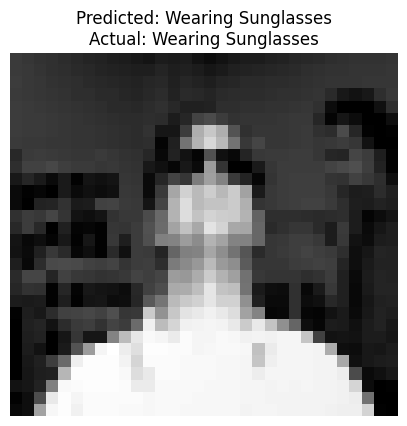

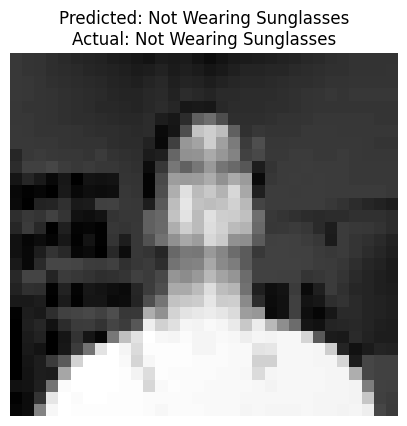

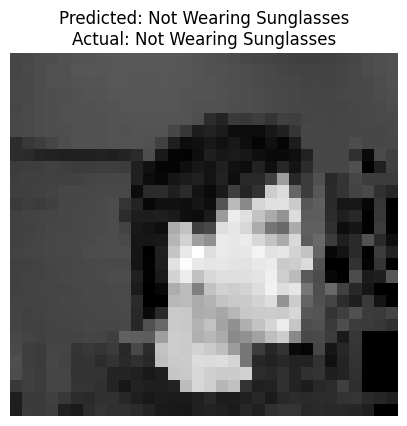

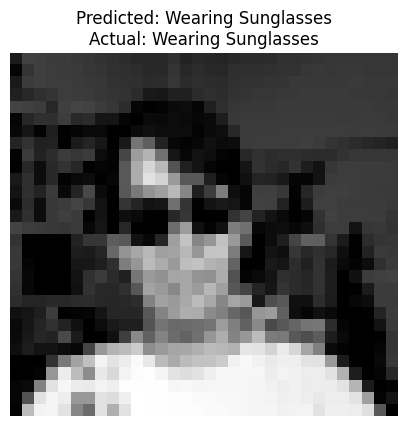

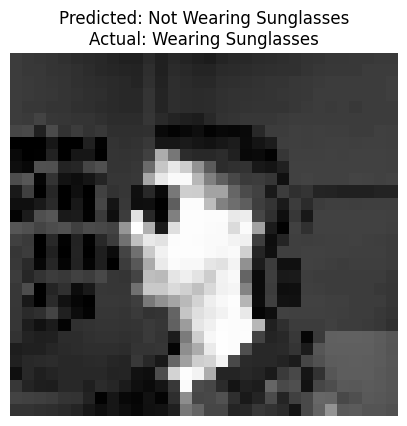

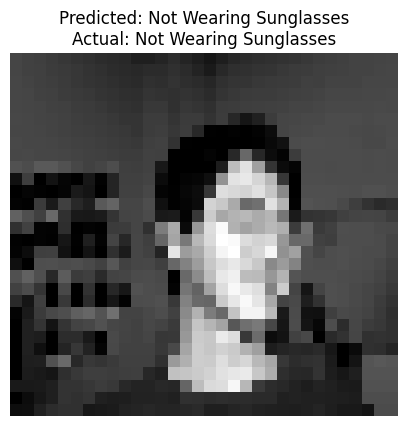

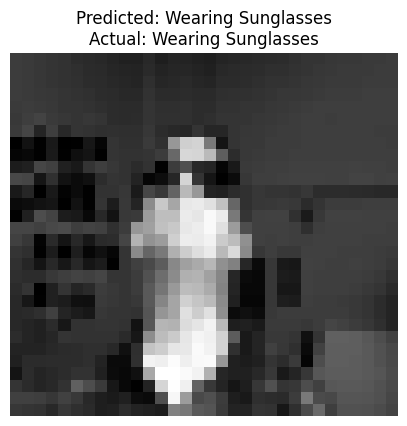

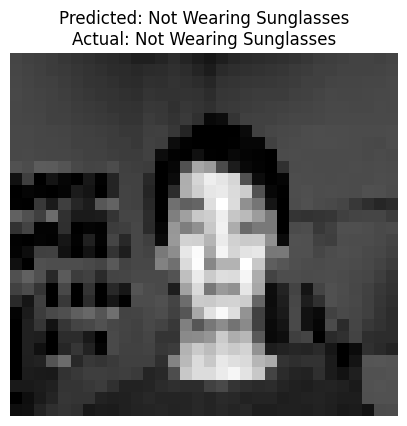

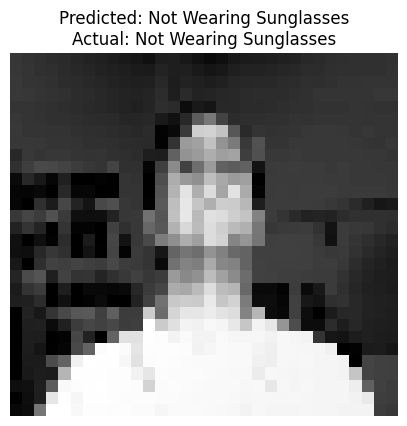

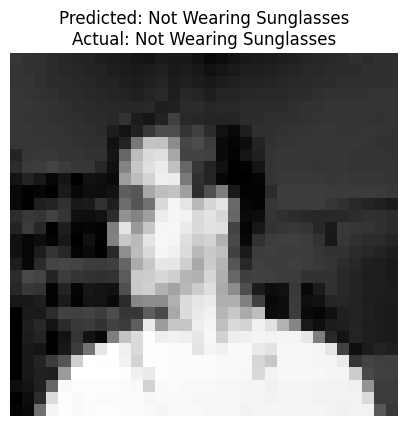

In [64]:
import os
import numpy as np
import cv2
import requests
from bs4 import BeautifulSoup
from PIL import Image
import matplotlib.pyplot as plt
import joblib

# Function to resize images to 32x30 and Normalize to [0,1]
def resize_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (32, 30))
    return resized_img / 255.0

# Function to parse labels from filenames
def parse_label(filename):
    if "sunglasses" in filename:
        return 1
    else:
        return 0

# Load the saved model
def load_model(model_path):
    loaded_model = joblib.load(model_path)
    return loaded_model

# Function to load sample data
def load_sample_data(sample_data_path):
    X_sample = []
    y_sample = []
    for file in os.listdir(sample_data_path):
        if file.endswith(".pgm"):
            image_path = os.path.join(sample_data_path, file)
            resized_image = resize_image(image_path)
            X_sample.append(resized_image.flatten())
            label = parse_label(file)
            y_sample.append(label)
    return np.array(X_sample), np.array(y_sample)

# Define the path to the saved model
model_path = '/googledrive/MyDrive/ML-LAB/ML-Assignment/sunglasses_prediction_model.pkl'

# Load the saved model
loaded_model = load_model(model_path)

# Define the path to the directory where the sample data is located
sample_data_path = "/googledrive/MyDrive/ML-LAB/ML-Assignment/Sunglasses_dataset"

# Load the sample data
X_sample, y_sample = load_sample_data(sample_data_path)

# Evaluate the loaded model on the sample data
sample_predictions = loaded_model.evaluate_accuracy(X_sample, y_sample.reshape(-1, 1))

# Calculate accuracy
accuracy = np.mean(sample_predictions == y_sample)
print("Accuracy on sample data:", accuracy)

# Function to display images with predicted labels
def display_images_with_predictions(X_sample, y_sample, predictions, max_images=10):
    images = []
    predicted_labels = []
    actual_labels = []
    num_images = min(len(X_sample), max_images)
    for i in range(num_images):
        image = X_sample[i].reshape(30, 32)  # Reshape image back to its original dimensions
        images.append(image)
        predicted_label = "Wearing Sunglasses" if predictions[i] == 1 else "Not Wearing Sunglasses"
        actual_label = "Wearing Sunglasses" if y_sample[i] == 1 else "Not Wearing Sunglasses"
        predicted_labels.append(predicted_label)
        actual_labels.append(actual_label)
    return images, predicted_labels, actual_labels

# Call the function to get images, predicted labels, and actual labels separately
images, predicted_labels, actual_labels = display_images_with_predictions(X_sample, y_sample, sample_predictions)

# Display images along with their predicted and actual labels
for i in range(len(images)):
    plt.figure(figsize=(5, 5))
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}\nActual: {actual_labels[i]}")
    plt.axis('off')
    plt.show()